In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from scipy.spatial.distance import cdist
from pyts.metrics import dtw as dtw2
import numpy as np
import scipy.stats as stats
from tsfresh.feature_extraction import extract_features
import zlib
import string
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN

def create_time_index(df):
    df = df.reset_index() # con indice numerico possiamo interare lungo il df normalmente
    #create the new index
    time=[]
    for i in df.index:
        h = df.loc[i]['hour']
        m = df.loc[i]['minute']
       
        time.append(str(h) + ":" + str(m))
    #substitute the old index with the new one
    df['time'] = time
    df = df.set_index('time')
    df = df.drop(columns=['date'])
    return df

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')

df_training = pd.read_csv('training.csv', parse_dates= True, index_col='date', date_parser=dateparse)
df_test = pd.read_csv('test.csv', parse_dates=True, index_col='date', date_parser=dateparse)

df = pd.concat([df_training, df_test], axis = 0)

C:\Users\dalla\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [3]:
df_test

,Unnamed: 0,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,minute,day_minute,cumulative_hour,cumulative_minute,weekend
date,,,,,,,,,,,,,,
2015-02-14 02:31:59,14392,19.790,36.290000,0.00,503.500000,0.005185,0,14,2,32,152,276,16573,1
2015-02-14 02:32:59,14393,19.790,36.290000,0.00,507.000000,0.005185,0,14,2,33,153,276,16574,1
2015-02-14 02:34:00,14394,19.790,36.290000,0.00,503.000000,0.005185,0,14,2,34,154,276,16575,1
2015-02-14 02:35:00,14395,19.790,36.290000,0.00,501.000000,0.005185,0,14,2,35,155,276,16576,1
2015-02-14 02:36:00,14396,19.760,36.363333,0.00,503.666667,0.005186,0,14,2,36,156,276,16577,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-18 09:15:00,20555,20.815,27.717500,429.75,1505.250000,0.004213,1,18,9,15,555,379,22736,0
2015-02-18 09:16:00,20556,20.865,27.745000,423.50,1514.500000,0.004230,1,18,9,16,556,379,22737,0
2015-02-18 09:16:59,20557,20.890,27.745000,423.50,1521.500000,0.004237,1,18,9,17,557,379,22738,0


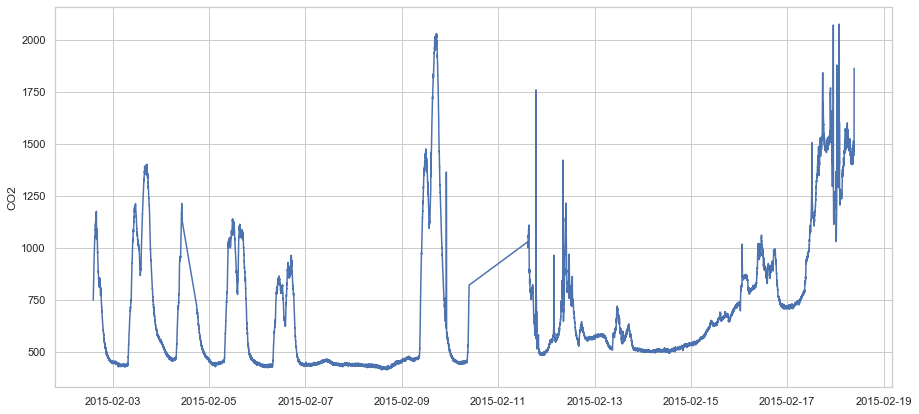

date
2015-02-02 14:19:00     749.200000
2015-02-02 14:19:59     760.400000
2015-02-02 14:21:00     769.666667
2015-02-02 14:22:00     774.750000
2015-02-02 14:23:00     779.000000
                          ...     
2015-02-18 09:15:00    1505.250000
2015-02-18 09:16:00    1514.500000
2015-02-18 09:16:59    1521.500000
2015-02-18 09:17:59    1632.000000
2015-02-18 09:19:00    1864.000000
Name: CO2, Length: 20560, dtype: float64

In [4]:
plt.figure(figsize=(15,7))
sns.set(style='whitegrid')
ts = df['CO2']
plt.ylabel('CO2')
plt.grid(True)
plt.plot(ts)
plt.show()
ts

# Create the new times series

Vengono estratte 12 time series di durata 24 ore, che corrispondono ai giorni nel dataset che hanno una copertura di dati completa

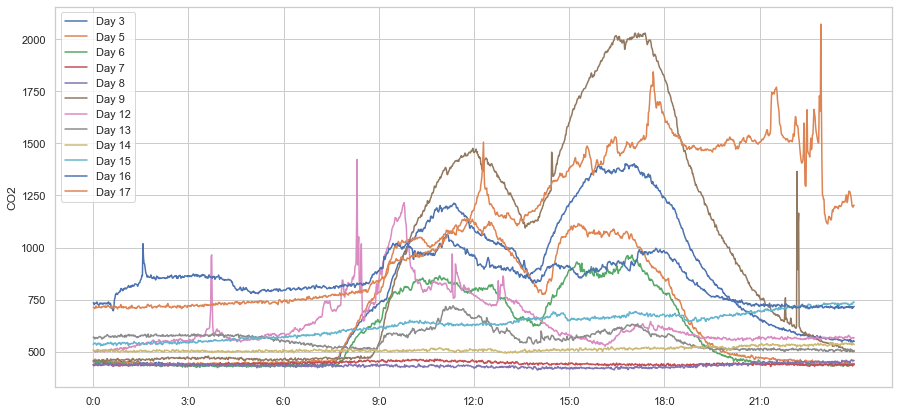

In [5]:

ts3 = df.loc[df['day'] == 3] #martedì 4 febbraio
ts5 = df.loc[df['day'] == 5] #giovedì 5 febbraio
ts6 = df.loc[df['day'] == 6] # ...
ts7 = df.loc[df['day'] == 7] #weekend
ts8 = df.loc[df['day'] == 8] #weekend
ts9 = df.loc[df['day'] == 9] # primo salto temporale (interruzione delle registrazioni nei giorni 10 e 11)
ts12 = df.loc[df['day'] == 12]
ts13 = df.loc[df['day'] == 13]
ts14 = df.loc[df['day'] == 14] #weekend
ts15 = df.loc[df['day'] == 15] #weekend
ts16 = df.loc[df['day'] == 16]
ts17 = df.loc[df['day'] == 17]


ts3 = create_time_index(ts3)
ts5 = create_time_index(ts5)
ts6 = create_time_index(ts6)
ts7 = create_time_index(ts7)
ts8 = create_time_index(ts8)
ts9 = create_time_index(ts9)
ts12 = create_time_index(ts12)
ts13 = create_time_index(ts13)
ts14 = create_time_index(ts14)
ts15 = create_time_index(ts15)
ts16 = create_time_index(ts16)
ts17 = create_time_index(ts17)

plt.figure(figsize=(15,7))
ts3 = ts3['CO2']
ts5 = ts5['CO2']
ts6 = ts6['CO2']
ts7 = ts7['CO2']
ts8 = ts8['CO2']
ts9 = ts9['CO2']
ts12 = ts12['CO2']
ts13 = ts13['CO2']
ts14 = ts14['CO2']
ts15 = ts15['CO2']
ts16 = ts16['CO2']
ts17 = ts17['CO2']


sns.set(style = 'whitegrid')
plt.ylabel('CO2')
plt.plot(ts3)
plt.plot(ts5)
plt.plot(ts6)
plt.plot(ts7)
plt.plot(ts8)
plt.plot(ts9)
plt.plot(ts12)
plt.plot(ts13)
plt.plot(ts14)
plt.plot(ts15)
plt.plot(ts16)
plt.plot(ts17)
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.show()

In [6]:
ts3

time
0:0      451.500000
0:1      455.250000
0:2      455.250000
0:3      451.666667
0:4      451.000000
            ...    
23:55    547.750000
23:56    547.250000
23:57    551.500000
23:58    554.000000
23:59    550.000000
Name: CO2, Length: 1440, dtype: float64

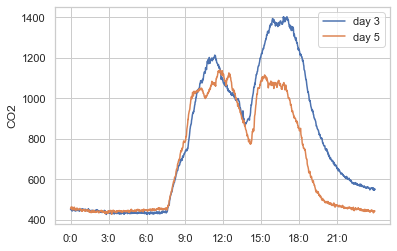

In [7]:
sns.set(style = 'whitegrid')
plt.ylabel('CO2')
plt.plot(ts3)
plt.plot(ts5)
plt.legend(["day 3", 'day 5'])
plt.xticks(range(0, 1440, 180))
plt.show()

# Transformations

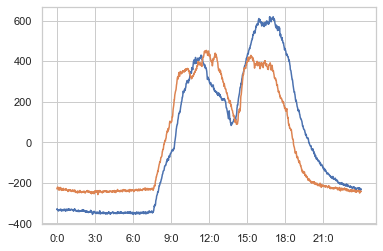

In [8]:
plt.plot(ts3 - ts3.mean())
plt.plot(ts5 - ts5.mean())
plt.xticks(range(0, 1440, 180))
plt.show()

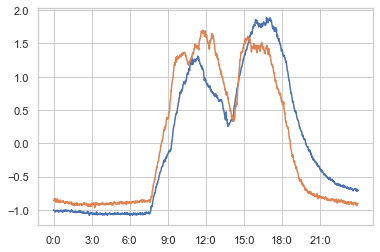

In [9]:
plt.plot((ts3 - ts3.mean())/ts3.std())
plt.plot((ts5 - ts5.mean())/ts5.std())
plt.xticks(range(0, 1440, 180))
plt.show()

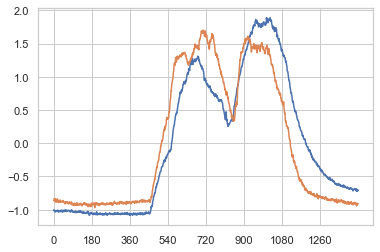

In [10]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts3_scaled = scaler.fit_transform(ts3).flatten()
ts5_scaled = scaler.fit_transform(ts5).flatten()

plt.plot(ts3_scaled)
plt.plot(ts5_scaled)
plt.xticks(range(0, 1440, 180))
plt.show()

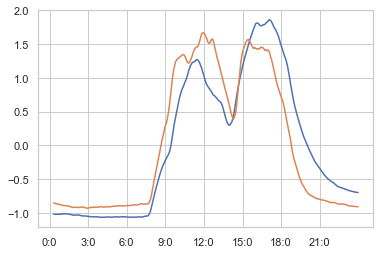

In [11]:
w = 20
plt.plot(((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean())
plt.plot(((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean())
plt.xticks(range(0, 1440, 180))
plt.show()

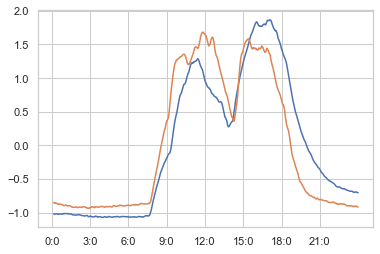

In [12]:
w = 10
plt.plot(((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean())
plt.plot(((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean())
plt.xticks(range(0, 1440, 180))

ts3_smooth = ((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean()
ts5_smooth = ((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean()
plt.show()

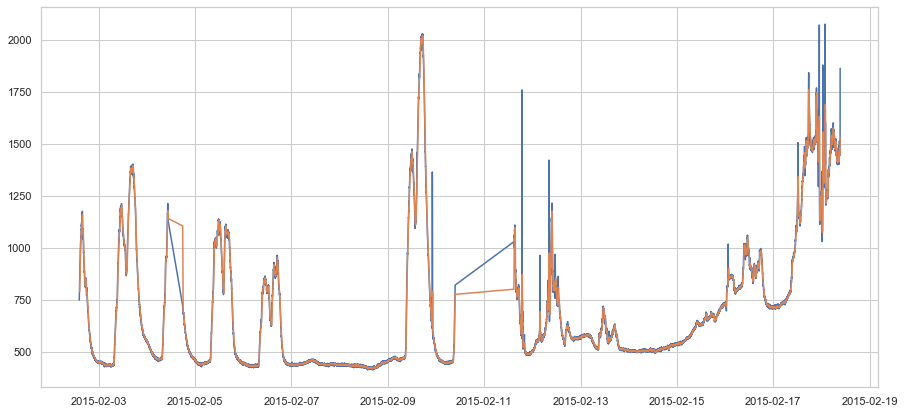

In [13]:
plt.figure(figsize=(15,7))
plt.plot(ts)
plt.plot(ts.rolling(window=12).mean())
plt.show()

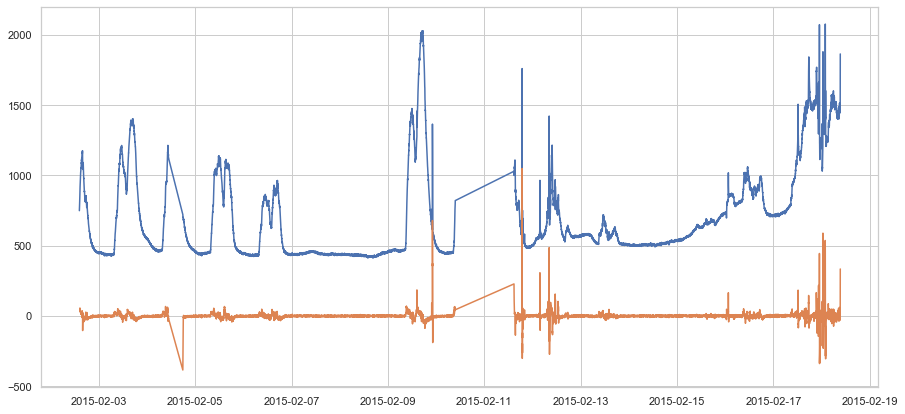

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(ts)
ts_shift = ts - ts.rolling(window=12).mean()
plt.plot(ts_shift)
plt.show()

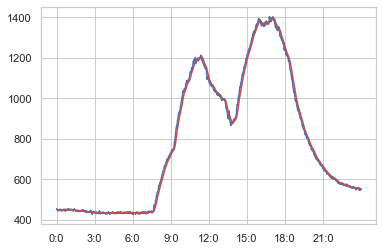

In [15]:
plt.plot(ts3, color = 'b')
plt.plot(ts3.rolling(window=12).mean(), color='r')
plt.xticks(range(0, 1440, 180))
plt.show()

# Distances

## Euclidean distance

In [16]:
#fino a qui nessun cambiamento del formato della ts
ts3

time
0:0      451.500000
0:1      455.250000
0:2      455.250000
0:3      451.666667
0:4      451.000000
            ...    
23:55    547.750000
23:56    547.250000
23:57    551.500000
23:58    554.000000
23:59    550.000000
Name: CO2, Length: 1440, dtype: float64

In [17]:
dist = euclidean(ts3, ts5)
dist

6489.991076378386

In [18]:
ts3_smooth = ts3_smooth[9:]
ts5_smooth = ts5_smooth[9:]
euclidean(ts3_smooth[9:], ts5_smooth[9:])

16.167052281432355

In [19]:
dist = cityblock(ts3, ts5)
dist

167283.51190476192

In [20]:
dist = cityblock(ts3_smooth, ts5_smooth)
dist

504.3588318593949

## DTW

In [21]:
path, dist = dtw_path(ts3, ts5)

In [22]:
dist

3450.8712174795382

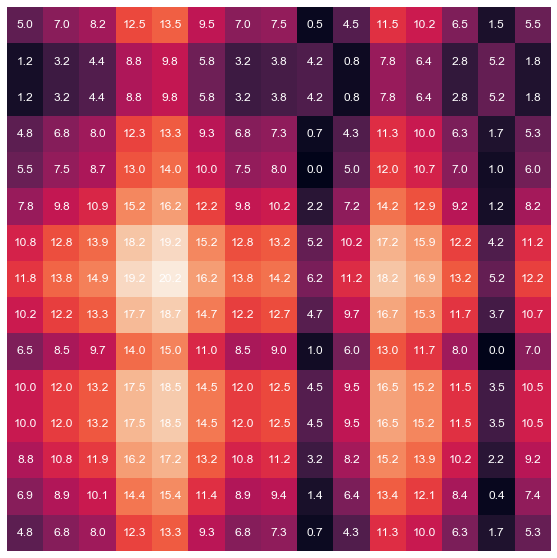

In [23]:
mat = cdist(ts3.values[:15].reshape(-1,1), ts5.values[:15].reshape(-1,1))

plt.figure(figsize=(10, 10))
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        text = plt.text(j, i, '%.1f' % mat[i, j], ha="center", va="center", color="w")
        
plt.show()

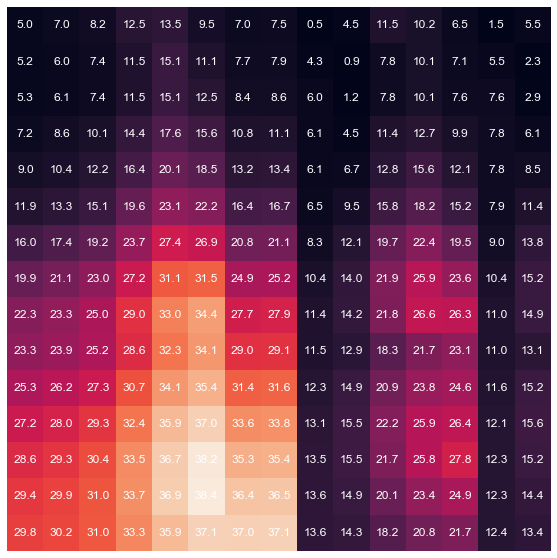

In [24]:
acc = subsequence_cost_matrix(ts3.values[:15].reshape(-1,1), ts5.values[:15].reshape(-1,1))

plt.figure(figsize=(10, 10))
plt.imshow(acc)
plt.axis("off")
plt.autoscale(False)
for i in range(acc.shape[0]):
    for j in range(acc.shape[1]):
        text = plt.text(j, i, '%.1f' % np.sqrt(acc[i, j]), ha="center", va="center", color="w")
        
plt.show()

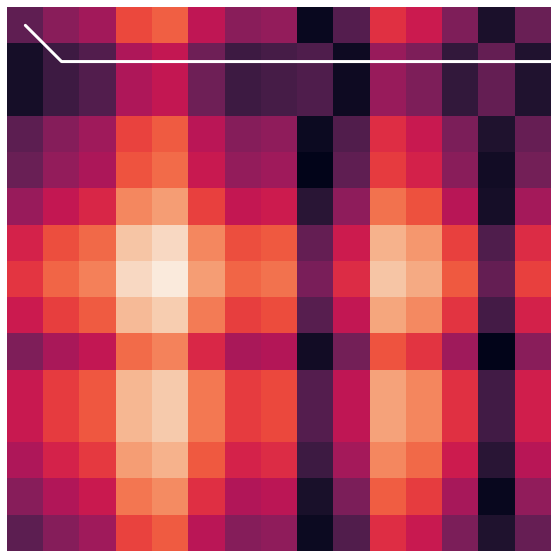

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

In [26]:
path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="sakoe_chiba", sakoe_chiba_radius=5)
dist

27.402002157182068

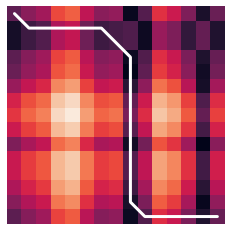

In [27]:
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

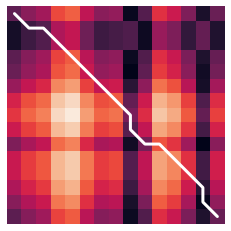

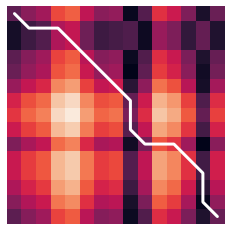

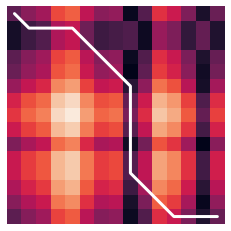

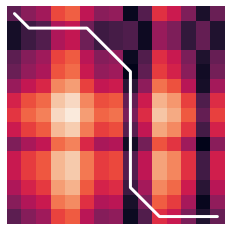

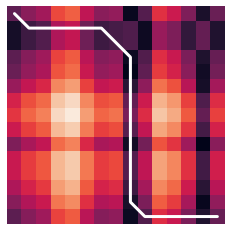

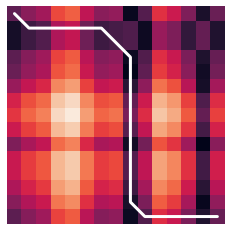

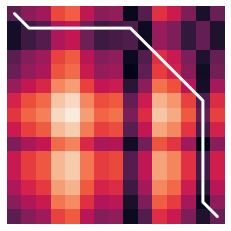

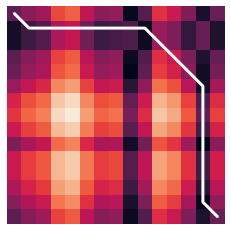

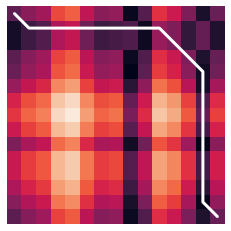

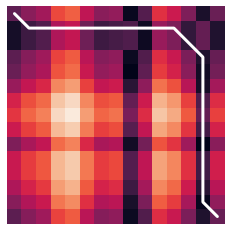

In [28]:
for i in range(1, 11):
    path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="sakoe_chiba", sakoe_chiba_radius=i)
    plt.imshow(mat)
    plt.axis("off")
    plt.autoscale(False)
    plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
    plt.show()

In [29]:
path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="itakura", itakura_max_slope=6.)
dist

29.009821133923484

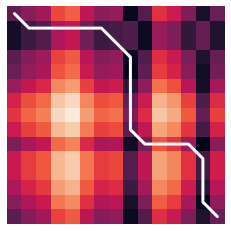

In [30]:
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

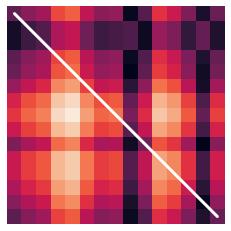

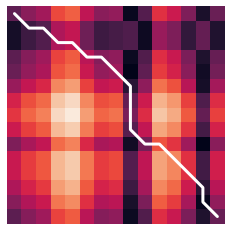

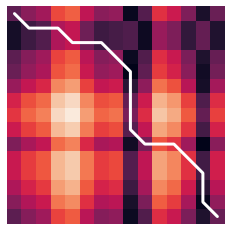

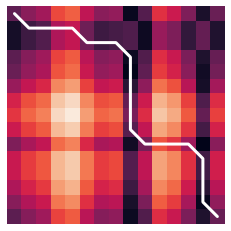

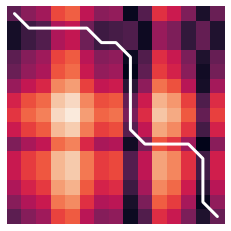

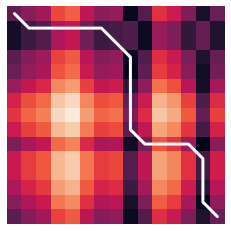

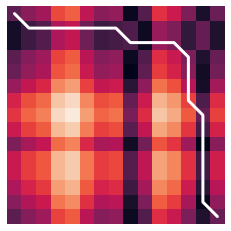

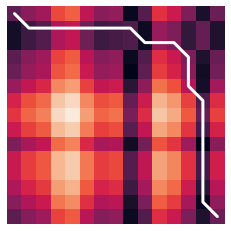

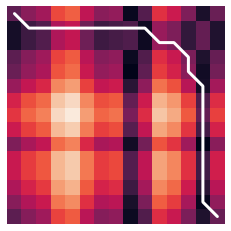

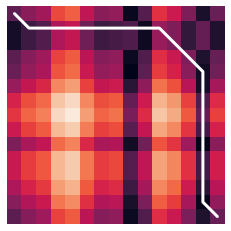

In [31]:
for i in range(1, 11):
    path, dist = dtw_path(ts3[:15], ts5[:15], global_constraint="itakura", itakura_max_slope=i)
    plt.imshow(mat)
    plt.axis("off")
    plt.autoscale(False)
    plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
    plt.show()

In [32]:
dtw2(ts3.ravel(), ts5.ravel())

3450.8712174795382

In [33]:
%%time
dtw2(ts3.ravel(), ts5.ravel(), dist='absolute')

Wall time: 789 ms


75795.13809523806

In [34]:
dtw2(ts3.ravel(), ts5.ravel(), dist='square', method='fast')

6489.991076378391

In [35]:
%%time
dtw2(ts3.ravel(), ts5.ravel(), dist='absolute', method='fast')

Wall time: 490 ms


167283.5119047619

## Features extraction

In [36]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [37]:
features = calculate_features(ts)

In [38]:
features

{'avg': 690.5532762414307,
 'std': 311.19371274221965,
 'var': 96841.52685028712,
 'med': 565.4166666666665,
 '10p': 438.0,
 '25p': 460.0,
 '50p': 565.4166666666665,
 '75p': 804.666666666667,
 '90p': 1152.0,
 'iqr': 344.66666666666697,
 'cov': 2.219046362332703,
 'skw': 1.6541838668310276,
 'kur': 2.3941410236046208}

In [39]:
print(calculate_features(ts3), end="\n\n")
print(calculate_features(ts5), end="\n\n")
print(calculate_features(ts6), end="\n\n")
print(calculate_features(ts7), end="\n\n")
print(calculate_features(ts8), end="\n\n")
print(calculate_features(ts9), end="\n\n")
print(calculate_features(ts12), end="\n\n")
print(calculate_features(ts13), end="\n\n")
print(calculate_features(ts14), end="\n\n")
print(calculate_features(ts15), end="\n\n")
print(calculate_features(ts16), end="\n\n")
print(calculate_features(ts17), end="\n\n")

{'avg': 783.349809027778, 'std': 327.8715744950798, 'var': 107499.76936188267, 'med': 689.0, '10p': 435.59000000000003, '25p': 445.72916666666674, '50p': 689.0, '75p': 1071.1875, '90p': 1285.3999999999971, 'iqr': 625.4583333333333, 'cov': 2.389197081918833, 'skw': 0.4341153383151239, 'kur': -1.269150206006757}

{'avg': 685.9395081018519, 'std': 266.335040905617, 'var': 70934.3540141967, 'med': 503.0, '10p': 443.0, '25p': 449.0, '50p': 503.0, '75p': 1002.0625, '90p': 1073.025, 'iqr': 553.0625, 'cov': 2.5754760085997583, 'skw': 0.47389035427141835, 'kur': -1.5414819974923486}

{'avg': 597.6440509259255, 'std': 181.0891625016953, 'var': 32793.28477556541, 'med': 479.0, '10p': 432.97499999999997, '25p': 437.0, '50p': 479.0, '75p': 793.4375, '90p': 865.0, 'iqr': 356.4375, 'cov': 3.3002750836639962, 'skw': 0.5206754395529377, 'kur': -1.4047797953654604}

{'avg': 443.59, 'std': 7.427396571494417, 'var': 55.16621983024702, 'med': 441.5, '10p': 435.6500000000003, '25p': 438.3124999999997, '50p'

## Compression based distances

In [40]:
def CDM(x, y):
    return len(zlib.compress(x + y)) / (len(zlib.compress(x)) + len(zlib.compress(y)))

In [41]:
ts3_str = (' '.join([str(v) for v in ts3[:10]])).encode('utf-8')
ts3_str

b'451.5 455.25 455.25 451.666666666667 451.0 448.75 445.75 444.75 446.333333333333 450.0'

In [42]:
ts5_str = (' '.join([str(v) for v in ts5[:10]])).encode('utf-8')
ts5_str

b'456.5 458.5 459.666666666667 464.0 465.0 461.0 458.5 459.0 451.0 456.0'

In [43]:
print("len(ts1_str + ts2_str): ", len(ts3_str + ts5_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_str+ts5_str)))
print("len(compress(ts1_str)): ", len(zlib.compress(ts3_str)))
print("len(compress(ts2_str)): ", len(zlib.compress(ts5_str)))
print("CDM = ", CDM(ts3_str, ts5_str))

len(ts1_str + ts2_str):  156
len(compress(ts1_str+ts2_str)):  76
len(compress(ts1_str)):  53
len(compress(ts2_str)):  45
CDM =  0.7755102040816326


In [44]:
ts3_str = (' '.join([str(v) for v in ts3])).encode('utf-8')
ts5_str = (' '.join([str(v) for v in ts5])).encode('utf-8')

print("len(ts1_str + ts2_str): ", len(ts3_str + ts5_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_str+ts5_str)))
print("len(compress(ts1_str)): ", len(zlib.compress(ts3_str)))
print("len(compress(ts2_str)): ", len(zlib.compress(ts5_str)))
print("CDM = ", CDM(ts3_str, ts5_str))

len(ts1_str + ts2_str):  23683
len(compress(ts1_str+ts2_str)):  6433
len(compress(ts1_str)):  3480
len(compress(ts2_str)):  2912
CDM =  1.0064142678347936


# Approximation

## Cella dove vengono trasformate le time series
le times series in formati deiversi mantengono nomi diversi in modo da poter essere successivamente usate:
- ts#_res = rescaled time series (tipo numpy)
- ts# = time serie con dati non trasformati (tipo pandas)

In [45]:
ts3

time
0:0      451.500000
0:1      455.250000
0:2      455.250000
0:3      451.666667
0:4      451.000000
            ...    
23:55    547.750000
23:56    547.250000
23:57    551.500000
23:58    554.000000
23:59    550.000000
Name: CO2, Length: 1440, dtype: float64

In [46]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.) # Rescale time series
ts3_res = scaler.fit_transform(ts3)
ts5_res = scaler.fit_transform(ts5)
ts6_res = scaler.fit_transform(ts6)
ts7_res = scaler.fit_transform(ts7)
ts8_res = scaler.fit_transform(ts8)
ts9_res = scaler.fit_transform(ts9)
ts12_res = scaler.fit_transform(ts12)
ts13_res = scaler.fit_transform(ts13)
ts14_res = scaler.fit_transform(ts14)
ts15_res = scaler.fit_transform(ts15)
ts16_res = scaler.fit_transform(ts16)
ts17_res = scaler.fit_transform(ts17)

In [47]:
ts3_res

array([[[-1.01213351],
        [-1.00069611],
        [-1.00069611],
        ...,
        [-0.70713605],
        [-0.69951111],
        [-0.71171101]]])

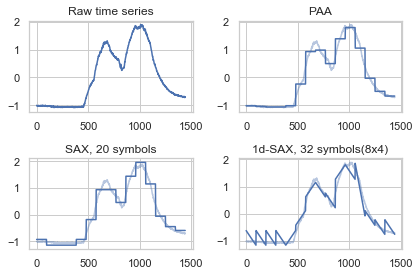

In [48]:
# PAA transform (and inverse transform) of the data

ts = ts3_res # ts era la time series che prendeva le due settimance, per le trasformazioni prendo una ts che dura 1 giorno
n_paa_segments = 15
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(ts)
paa_dataset_inv = paa.inverse_transform(ts_paa)

# SAX transform
n_sax_symbols = 20
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts)
sax_dataset_inv = sax.inverse_transform(ts_sax) # inverse_transform trasforma le etichette adattandole al range dei valori nella ts

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 4
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)

ts_sax1d = one_d_sax.fit_transform(ts)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(ts_sax1d)

plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(ts[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(ts[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(ts[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(ts[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

In [49]:
sax_dataset_inv

array([[[-0.93458929],
        [-0.93458929],
        [-0.93458929],
        ...,
        [-0.59776013],
        [-0.59776013],
        [-0.59776013]]])

In [50]:
ts[0].ravel()

array([-1.01213351, -1.00069611, -1.00069611, ..., -0.70713605,
       -0.69951111, -0.71171101])

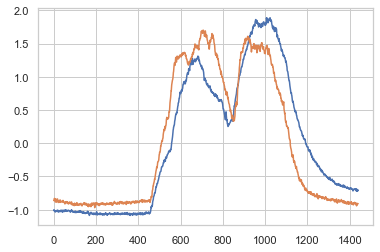

In [51]:
plt.plot(ts3_res[0].ravel())
plt.plot(ts5_res[0].ravel())
plt.show()

In [52]:
ts3_res_paa = paa.fit_transform(ts3_res)
ts5_res_paa = paa.fit_transform(ts5_res)

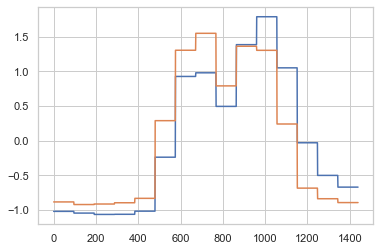

In [53]:
plt.plot(paa.inverse_transform(ts3_res_paa)[0].ravel())
plt.plot(paa.inverse_transform(ts5_res_paa)[0].ravel())
plt.show()

In [54]:
ts3_res_str = (' '.join([str(v) for v in ts3_res_paa[0].ravel()])).encode('utf-8')
ts5_res_str = (' '.join([str(v) for v in ts5_res_paa[0].ravel()])).encode('utf-8')

print("len(ts3_res_str + ts5_res_str): ", len(ts3_res_str + ts5_res_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_res_str+ts5_res_str)))
print("len(compress(ts1_str)): ", len(zlib.compress(ts3_res_str)))
print("len(compress(ts2_str)): ", len(zlib.compress(ts5_res_str)))
print("CDM = ", CDM(ts3_res_str, ts5_res_str))

len(ts3_res_str + ts5_res_str):  581
len(compress(ts1_str+ts2_str)):  296
len(compress(ts1_str)):  162
len(compress(ts2_str)):  159
CDM =  0.9221183800623053


In [55]:
ts3_res_sax = sax.fit_transform(ts3_res)
ts5_res_sax = sax.fit_transform(ts5_res)

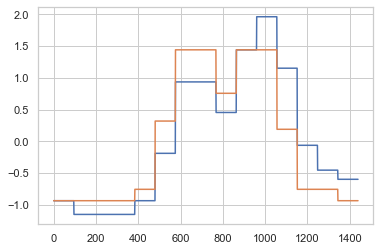

In [56]:
plt.plot(sax.inverse_transform(ts3_res_sax)[0].ravel())
plt.plot(sax.inverse_transform(ts5_res_sax)[0].ravel())
plt.show()

In [57]:
ts3_res_sax1d = one_d_sax.fit_transform(ts3_res)
ts5_res_sax1d = one_d_sax.fit_transform(ts5_res)

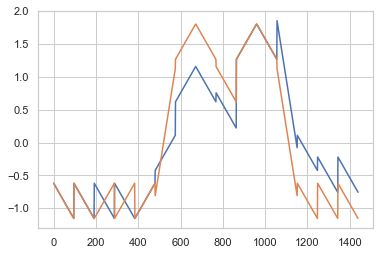

In [58]:
plt.plot(one_d_sax.inverse_transform(ts3_res_sax1d)[0].ravel())
plt.plot(one_d_sax.inverse_transform(ts5_res_sax1d)[0].ravel())
plt.show()

In [59]:
ts3_res_str = (' '.join([str(v) for v in ts3_res_sax1d[0].ravel()])).encode('utf-8')
ts5_res_str = (' '.join([str(v) for v in ts5_res_sax1d[0].ravel()])).encode('utf-8')

print("len(ts3_res_str + ts5_res_str): ", len(ts3_res_str + ts5_res_str))
print("len(compress(ts1_str+ts2_str)): ", len(zlib.compress(ts3_res_str+ts5_res_str)))
print("len(compress(ts3_res_str)): ", len(zlib.compress(ts3_res_str)))
print("len(compress(ts5_res_str)): ", len(zlib.compress(ts5_res_str)))
print("CDM = ", CDM(ts3_res_str, ts5_res_str))

len(ts3_res_str + ts5_res_str):  118
len(compress(ts1_str+ts2_str)):  53
len(compress(ts3_res_str)):  38
len(compress(ts5_res_str)):  35
CDM =  0.726027397260274


# Data preparation for clustering

Come per le ts sopra, anche per X vengono create due versioni
- X : matrice con le ts senza trasformazione ma con noise reduction
- X_res_nr : matrice con le ts trasformate e noise reduction

In [60]:
# ts3, ts5, .... non sono normalizzate con TimeSeriesScalerMeanVariance perché i risultati sono migliori
# rispetto alla controparte trasformata.
X = np.array([ts3.rolling(window=30).mean(),
              ts5.rolling(window=30).mean(),
              ts6.rolling(window=30).mean(),
              ts7.rolling(window=30).mean(),
              ts8.rolling(window=30).mean(),
              ts9.rolling(window=30).mean(),
              ts12.rolling(window=30).mean(),
              ts13.rolling(window=30).mean(),
              ts14.rolling(window=30).mean(),
              ts15.rolling(window=30).mean(),
              ts16.rolling(window=30).mean(),
              ts17.rolling(window=30).mean(),])

# problema: i primi 29 valori (window -1) contengono 'nan'
X_new = np.empty((12, 1411))
for i in range(len(X)):
    X_new[i] = X[i][29:] #tolgo valori nan con slicing
X = X_new

X.shape

(12, 1411)

In [61]:
# nuova versione di time series e X_res con Noise Reduction
w=30
ts3_res_nr = ((ts3 - ts3.mean())/ts3.std()).rolling(window=w).mean()
ts5_res_nr = ((ts5 - ts5.mean())/ts5.std()).rolling(window=w).mean()
ts6_res_nr = ((ts6 - ts6.mean())/ts6.std()).rolling(window=w).mean()
ts7_res_nr = ((ts7 - ts7.mean())/ts7.std()).rolling(window=w).mean()
ts8_res_nr = ((ts8 - ts8.mean())/ts8.std()).rolling(window=w).mean()
ts9_res_nr = ((ts9 - ts9.mean())/ts9.std()).rolling(window=w).mean()
ts12_res_nr = ((ts12 - ts12.mean())/ts12.std()).rolling(window=w).mean()
ts13_res_nr = ((ts13 - ts13.mean())/ts13.std()).rolling(window=w).mean()
ts14_res_nr = ((ts14 - ts14.mean())/ts14.std()).rolling(window=w).mean()
ts15_res_nr = ((ts15 - ts15.mean())/ts15.std()).rolling(window=w).mean()
ts16_res_nr = ((ts16 - ts16.mean())/ts16.std()).rolling(window=w).mean()
ts17_res_nr = ((ts17 - ts17.mean())/ts17.std()).rolling(window=w).mean()

X_res_nr = np.array([ts3_res_nr,
             ts5_res_nr,
             ts6_res_nr,
             ts7_res_nr,
             ts8_res_nr,
             ts9_res_nr,
             ts12_res_nr,
             ts13_res_nr,
             ts14_res_nr,
             ts15_res_nr,
             ts16_res_nr,
             ts17_res_nr])


# problema: i primi 29 valori (window -1) contengono 'nan'
X_res_nr_new = np.empty((12, 1411))
for i in range(len(X_res_nr)):
    X_res_nr_new[i] = X_res_nr[i][29:] #tolgo valori nan con slicing
X_res_nr = X_res_nr_new

X_res_nr.shape

(12, 1411)

In [62]:
len(X_res_nr)

12

# Clustering

## Clustering con distanza euclidea

- proviamo diverso numero di k (migliore k = 3)
- con dati senza trasformazione (K=2)
- con dati senza trasformazione (K=3)
- con dati trasformati ma vediamo che il cluster sono più disordinati (è rimasto solo il clustering con il DTW e K=3 perché lo abbiamo inserito nel report)

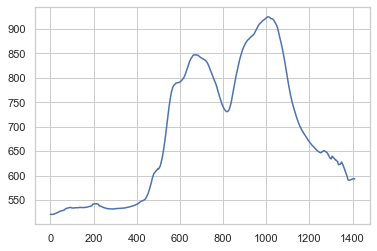

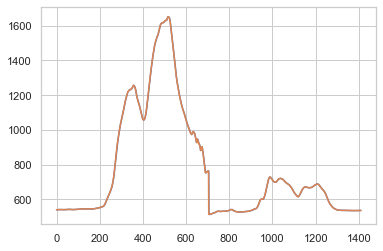

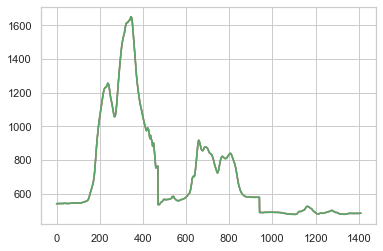

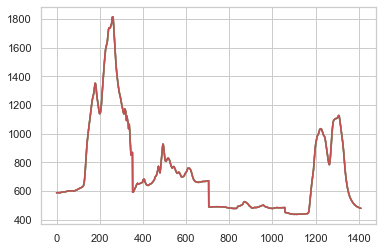

In [63]:
for i in range(1 ,5):
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=5, random_state=0)
    km.fit(X)
    plt.plot(km.cluster_centers_.reshape(X.shape[1], i))
    plt.show()

In [64]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([3, 3, 3, 2, 2, 0, 1, 2, 2, 1, 1, 0], dtype=int64)

In [65]:
# DA COPIARE SOTTO, QUANDO CALCOLO LE PAIRWISE DISTANCES PER DBSCAN
X_res = np.array([ts3_res[0].ravel(),
             ts5_res[0].ravel(),
             ts6_res[0].ravel(),
             ts7_res[0].ravel(),
             ts8_res[0].ravel(),
             ts9_res[0].ravel(),
             ts12_res[0].ravel(),
             ts13_res[0].ravel(),
             ts14_res[0].ravel(),
             ts15_res[0].ravel(),
             ts16_res[0].ravel(),
             ts17_res[0].ravel(),])
X_res.shape

(12, 1440)

In [66]:
X_res = np.array([ts3_res[0].ravel(),
             ts5_res[0].ravel(),
             ts6_res[0].ravel(),
             ts7_res[0].ravel(),
             ts8_res[0].ravel(),
             ts9_res[0].ravel(),
             ts12_res[0].ravel(),
             ts13_res[0].ravel(),
             ts14_res[0].ravel(),
             ts15_res[0].ravel(),
             ts16_res[0].ravel(),
             ts17_res[0].ravel(),])
X_res.shape

(12, 1440)

In [67]:
km.inertia_

20766905.798399474

### Dati originali K = 2

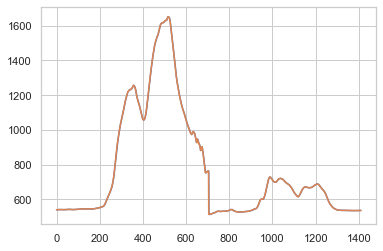

In [68]:
km = TimeSeriesKMeans(n_clusters=2, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)
plt.plot(km.cluster_centers_.reshape(X.shape[1], 2))
plt.show()

In [69]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int64)

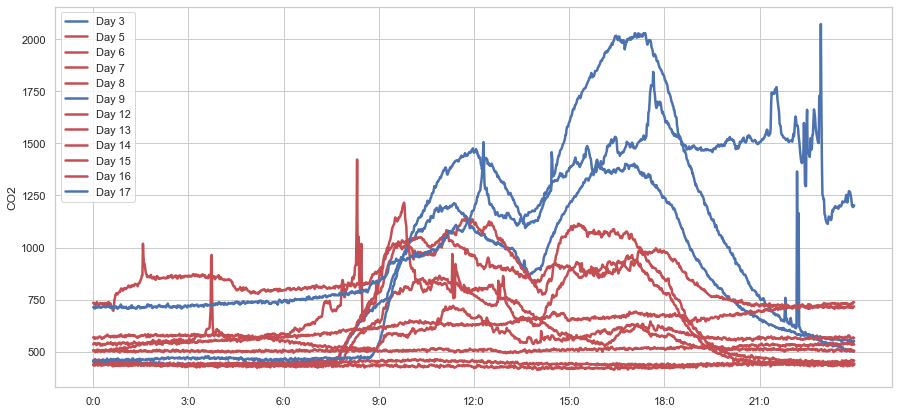

In [70]:
l = 2.5 #line width
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b", lw = l)
plt.plot(ts5, color = "r", lw = l)
plt.plot(ts6, color = "r", lw = l) #r
plt.plot(ts7, color = "r", lw = l)
plt.plot(ts8, color = "r", lw = l)
plt.plot(ts9, color = "b", lw = l)
plt.plot(ts12, color = "r", lw = l)
plt.plot(ts13, color = "r", lw = l) #g
plt.plot(ts14, color = "r", lw = l)
plt.plot(ts15, color = "r", lw = l)
plt.plot(ts16, color = "r", lw = l)
plt.plot(ts17, color = "b", lw = l)
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [71]:
inertia2 = km.inertia_ # per essere confrontato con gli altri andrebbe trasformato
inertia2

42609813.21769549

### Dati originali K = 3

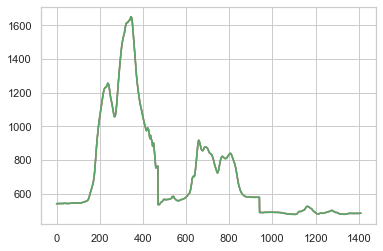

In [72]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)
plt.plot(km.cluster_centers_.reshape(X.shape[1], 3))
plt.show()

In [73]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 0], dtype=int64)

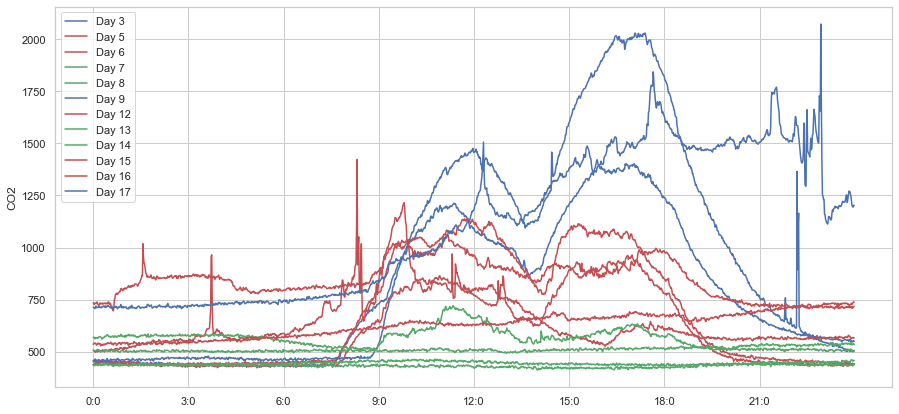

In [74]:

plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "r")
plt.plot(ts6, color = "r")
plt.plot(ts7, color = "g")
plt.plot(ts8, color = "g")
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "r")
plt.plot(ts13, color = "g")
plt.plot(ts14, color = "g")
plt.plot(ts15, color = "r")
plt.plot(ts16, color = "r")
plt.plot(ts17, color = "b") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [75]:
inertia3 = km.inertia_
inertia3

29201153.914079815

### Dati normalizzati K = 3

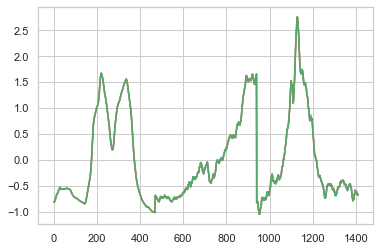

In [76]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_res_nr)
plt.plot(km.cluster_centers_.reshape(X_res_nr.shape[1], 3))
plt.show()

In [77]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 0, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1], dtype=int64)

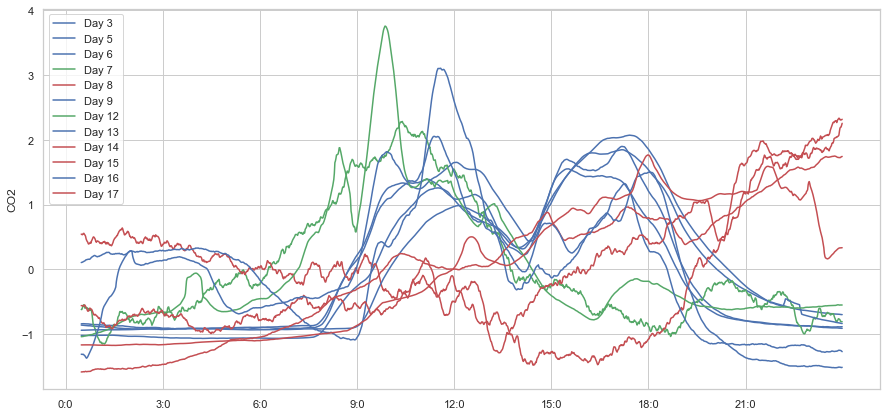

In [78]:
plt.figure(figsize = (15, 7))
plt.plot(ts3_res_nr, color = "b")
plt.plot(ts5_res_nr, color = "b")
plt.plot(ts6_res_nr, color = "b")
plt.plot(ts7_res_nr, color = "g")
plt.plot(ts8_res_nr, color = "r")
plt.plot(ts9_res_nr, color = "b")
plt.plot(ts12_res_nr, color = "g")
plt.plot(ts13_res_nr, color = "b")
plt.plot(ts14_res_nr, color = "r")
plt.plot(ts15_res_nr, color = "r")
plt.plot(ts16_res_nr, color = "b")
plt.plot(ts17_res_nr, color = "r") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [79]:
inertia_res3 = km.inertia_
inertia_res3

310.4393447500745

In [80]:
print("inertia k=2:                                    ", inertia2) # andrebbe trasformato per renderlo comparabile
print("inertia k=3:                                    ", inertia3)
print("inertia with trandfotmation and noise reduction:", inertia_res3)

inertia k=2:                                     42609813.21769549
inertia k=3:                                     29201153.914079815
inertia with trandfotmation and noise reduction: 310.4393447500745


In [81]:
print((inertia2 - X.mean()) / X.std())
print((inertia3 - X.mean()) / X.std())

141385.48322174134
96892.909047862


## Clustering con DTW

- proviamo diverso numero di k (migliore k = 3)
- con dati senza trasformazione K = 2
- con dati senza trasformazione K = 3

### Dati Originali K = 2

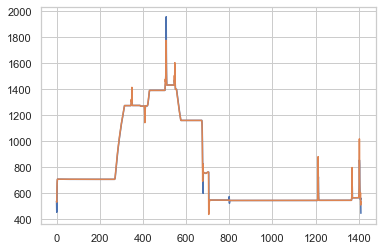

In [82]:
km_dtw = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 2))
plt.show()

In [83]:
km_dtw.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int64)

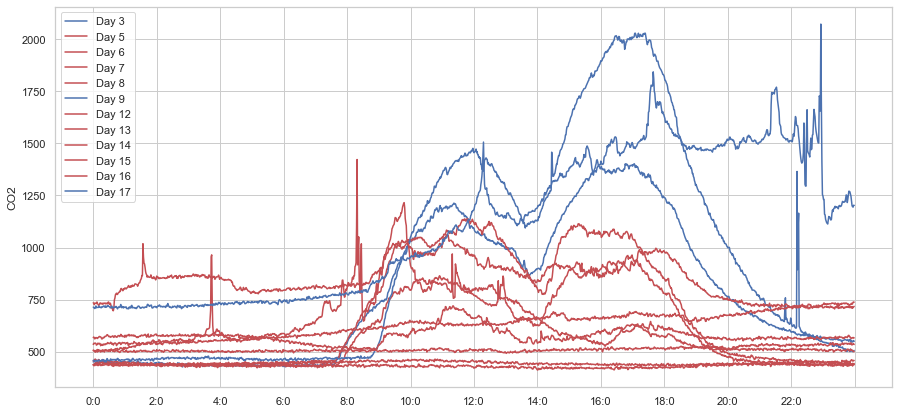

In [84]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "r")
plt.plot(ts6, color = "r")
plt.plot(ts7, color = "r") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "r")
plt.plot(ts13, color = "r") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "r")
plt.plot(ts17, color = "b") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1441, 120))
plt.ylabel('CO2')
plt.show()

In [85]:
inertia2 = km_dtw.inertia_
inertia2

8627494.811722081

### Dati originali K = 3

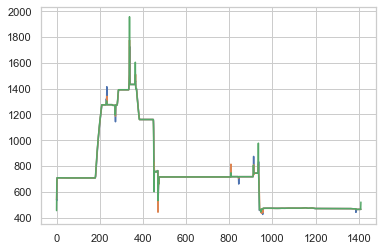

In [86]:
km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 3))
plt.show()

In [87]:
km_dtw.labels_

array([0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 0], dtype=int64)

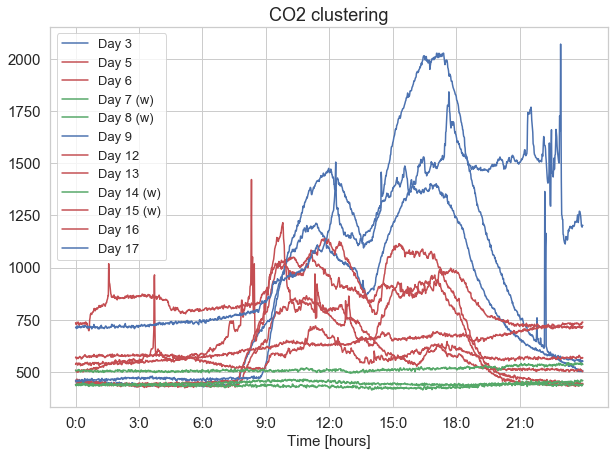

In [132]:
f=15
plt.figure(figsize = (10, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "r")
plt.plot(ts6, color = "r")
plt.plot(ts7, color = "g") #weekend
plt.plot(ts8, color = "g") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "r")
plt.plot(ts13, color = "r") 
plt.plot(ts14, color = "g") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "r")
plt.plot(ts17, color = "b") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7 (w)', 'Day 8 (w)', 'Day 9', 'Day 12', 'Day 13', 'Day 14 (w)', 'Day 15 (w)', 'Day 16', 'Day 17'], fontsize=f-2)
plt.xticks(range(0, 1440, 180), fontsize = f)
plt.yticks(fontsize=f)
plt.title("CO2 clustering", fontsize = f+3)
plt.xlabel('Time [hours]', fontsize=f)
plt.show()

In [89]:
inertia3 = km_dtw.inertia_
inertia3

2746691.504125687

In [94]:
print("inertia k=2:", inertia2) # andrebbe trasformato per renderlo comparabile
print("inertia k=3:", inertia3)

inertia k=2: 8627494.811722081
inertia k=3: 2746691.504125687


In [95]:
print((inertia2 - X.mean()) / X.std())
print((inertia3 - X.mean()) / X.std())

28625.453449752644
9111.78907506961


Per il report: metric = "DTW", k=3

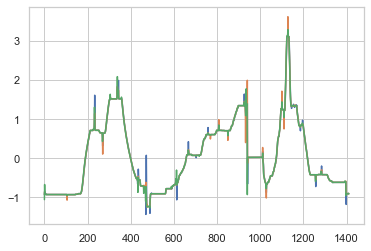

In [96]:
km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0)
km.fit(X_res_nr)
plt.plot(km.cluster_centers_.reshape(X_res_nr.shape[1], 3))
plt.show()

In [97]:
km.labels_ # 3 5 6 7 8 9 12 13 14 15 16 17

array([0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 0, 1], dtype=int64)

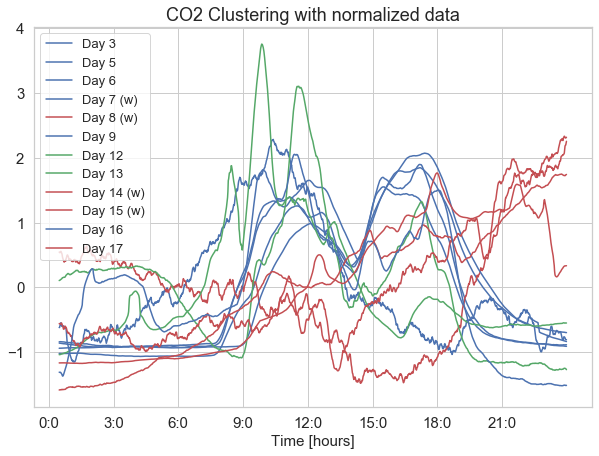

In [135]:
f=15
plt.figure(figsize = (10, 7))
plt.plot(ts3_res_nr, color = "b")
plt.plot(ts5_res_nr, color = "b")
plt.plot(ts6_res_nr, color = "b")
plt.plot(ts7_res_nr, color = "b")
plt.plot(ts8_res_nr, color = "r")
plt.plot(ts9_res_nr, color = "b")
plt.plot(ts12_res_nr, color = "g")
plt.plot(ts13_res_nr, color = "g")
plt.plot(ts14_res_nr, color = "r")
plt.plot(ts15_res_nr, color = "r")
plt.plot(ts16_res_nr, color = "b")
plt.plot(ts17_res_nr, color = "r") # same cluster as red ts
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7 (w)', 'Day 8 (w)', 'Day 9', 'Day 12', 'Day 13', 'Day 14 (w)', 'Day 15 (w)', 'Day 16', 'Day 17'], fontsize=f-2)
plt.xticks(range(0, 1440, 180), fontsize = f)
plt.yticks(fontsize=f)
plt.xlabel('Time [hours]', fontsize=f)
plt.title("CO2 Clustering with normalized data", fontsize = f+3)
plt.show()

## Feature Based Clustering

- con dati senza trasformazione K = 2
- con dati senza trasformazione K = 3

In [99]:
F = [list(calculate_features(x).values())[:-2] for x in X] # features dei dati originali

In [100]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

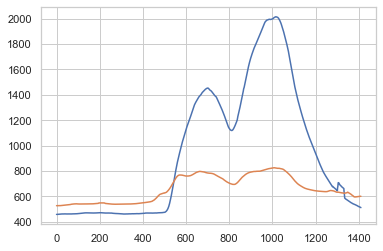

In [101]:
for i in range(2):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

### Dati senza trasformazione

In [102]:
kmeans.labels_

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

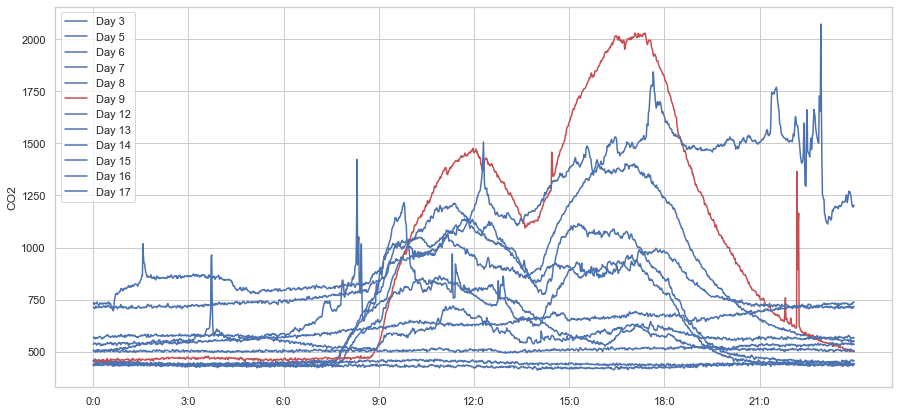

In [103]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "b") # weekend
plt.plot(ts9, color = "r")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "b") # weekend
plt.plot(ts15, color = "b") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "b")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [104]:
inertia2 = kmeans.inertia_
inertia2

19387799046.91401

### Dati originali K = 3

In [105]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [106]:
kmeans.labels_

array([0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0])

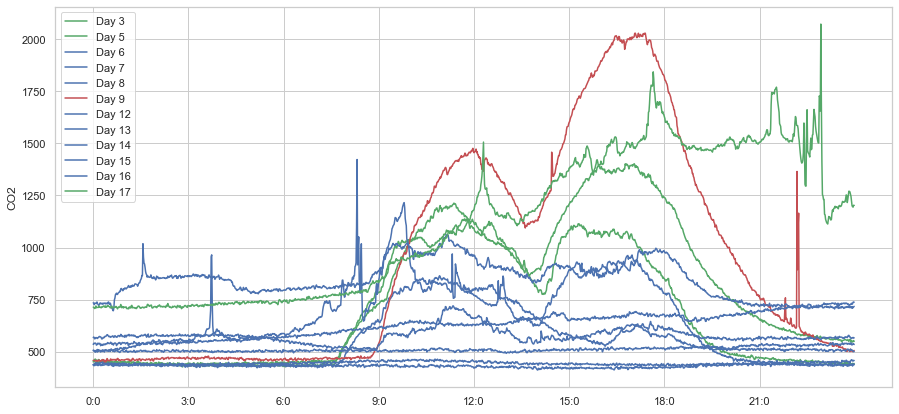

In [107]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "g")
plt.plot(ts5, color = "g")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "b") # weekend
plt.plot(ts9, color = "r")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "b") # weekend
plt.plot(ts15, color = "b") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "g")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

In [108]:
inertia3 = kmeans.inertia_
inertia3

1978244312.6885095

In [109]:
print("inertia k=2:", inertia2)
print("inertia k=3:", inertia3)

inertia k=2: 19387799046.91401
inertia k=3: 1978244312.6885095


## Compression based clustering

- con dati senza trasformazione
- con dati trasformati
- con dati trasformati e noise reduction

In [110]:
"""
cerchiamo di intuire cos'è:
osservando quello che restuisce la funzione (la divisione), si intuisce che più le ts sono simili, più il numero restituito è basso. questo perché zlib è una libreria di compressione di stringhe, dove però le informazioni all'iterno vengono mantenute. Noi intuiamo che più due ts sono simili, quando convertite in stringhe, la loro somma e compressione sia piccola. Al contrario se invece le ts sono diverse 

"""

def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [111]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)
# X.reshape() crea un array di 12 righe e 1411 colonne
M_res = pairwise_distances(X_res.reshape(X_res.shape[0], X_res.shape[1]), metric=cdm_dist)
M_res_nr = pairwise_distances(X_res_nr.reshape(X_res_nr.shape[0], X_res_nr.shape[1]), metric=cdm_dist)

In [112]:
ciao = X.reshape(X.shape[0], X.shape[1])

### Dati senza trasformazione

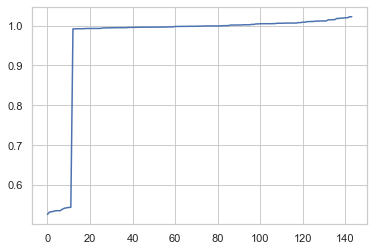

In [113]:
# stampo come array la matrice delle distanze (M). Cerchiamo poi un valore di epsilon che separi al meglio core, border e outliers
plt.plot(sorted(M.ravel()))
plt.plot(1, color = 'red')
plt.show()

eps = 0.999

In [114]:
dbscan = DBSCAN(eps=0.999, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.999, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [115]:
pippo = dbscan.labels_
pippo

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

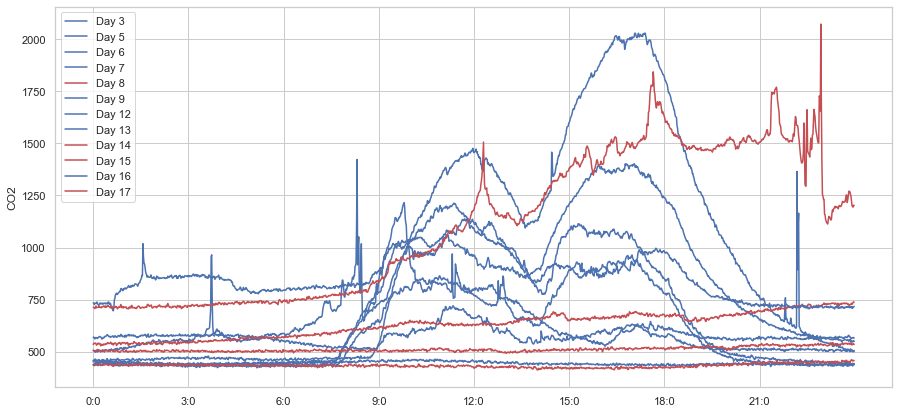

In [116]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

eps = 0.997

In [117]:
dbscan = DBSCAN(eps=0.997, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.997, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [118]:
pippo = dbscan.labels_
pippo

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

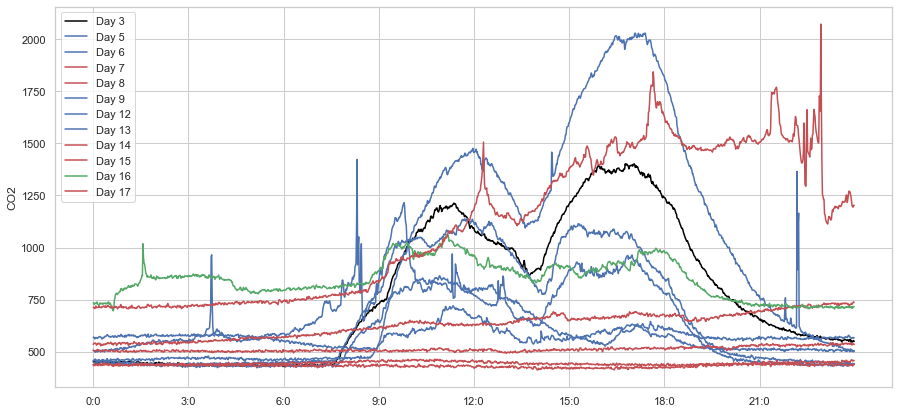

In [119]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "black")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "r") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "g")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

eps = 0.996

In [120]:
dbscan = DBSCAN(eps=0.996, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.996, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [121]:
pippo = dbscan.labels_
pippo

array([-1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

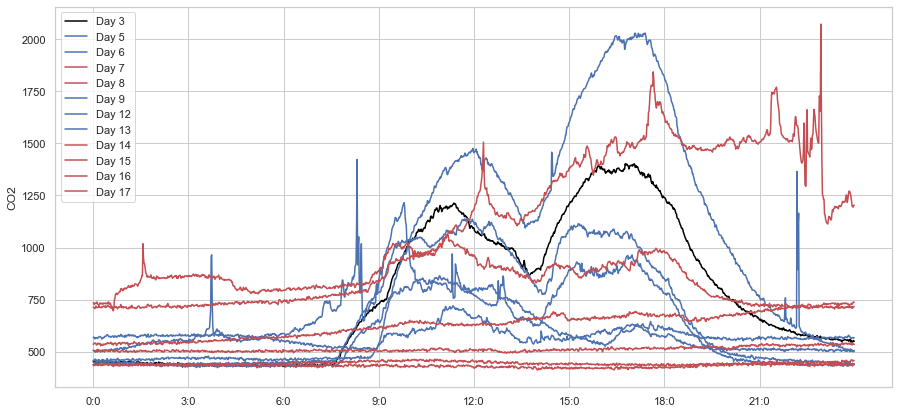

In [122]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "black")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "r") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "r")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

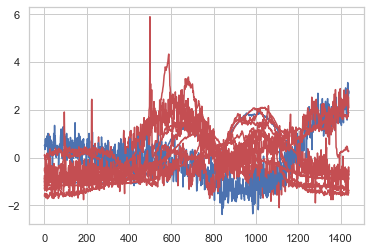

In [123]:
for i in range(len(X_res)):
    if pippo[i] == 0: # core
        #continue
        plt.plot(X_res[i], color='r')
    if pippo[i] == -1: #noise
        #continue
        plt.plot(X_res[i], color = 'b')
plt.show()

### Dati con trasformazione

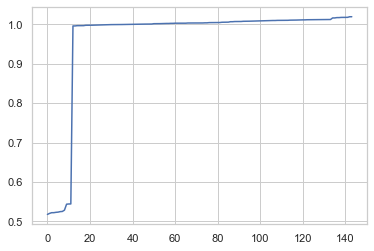

In [124]:
plt.plot(sorted(M_res.ravel()))
plt.show()

In [125]:
dbscan = DBSCAN(eps=0.999, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.999, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [126]:
pippo = dbscan.labels_
pippo

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

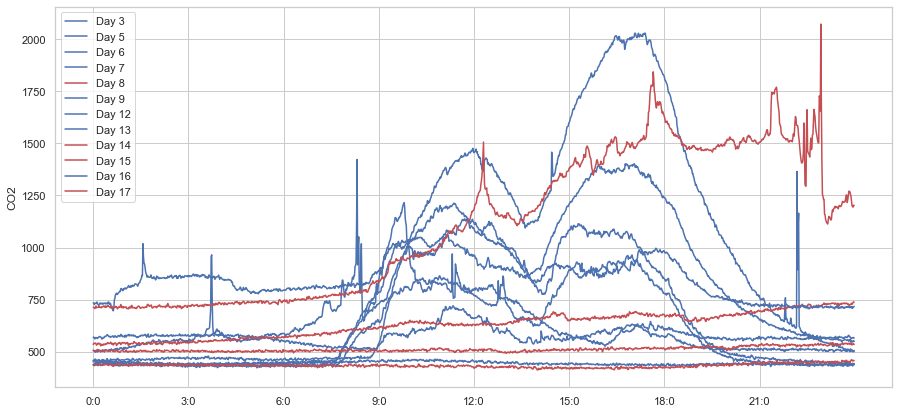

In [127]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()

### Dati con trasfomazione e noise reduction

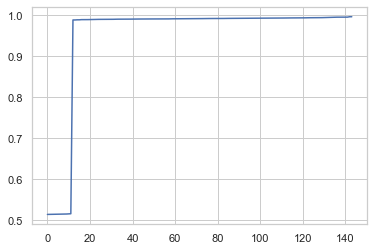

In [128]:
plt.plot(sorted(M_res_nr.ravel()))
plt.show()

In [129]:
dbscan = DBSCAN(eps=0.999, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.999, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [130]:
pippo = dbscan.labels_
pippo

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

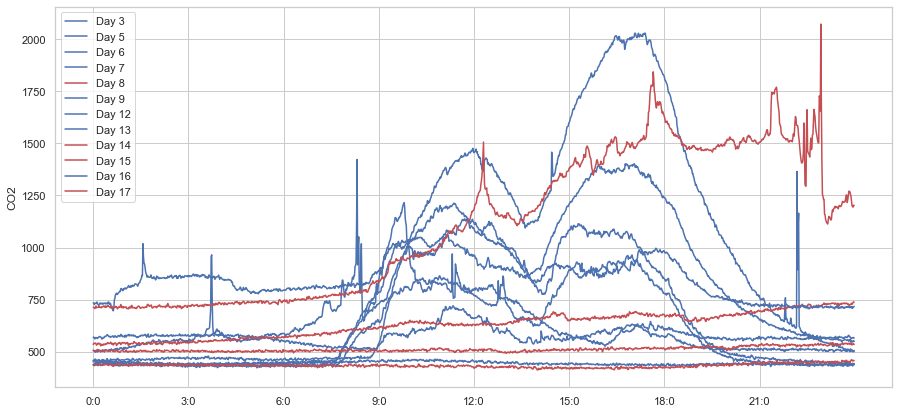

In [131]:
plt.figure(figsize = (15, 7))
plt.plot(ts3, color = "b")
plt.plot(ts5, color = "b")
plt.plot(ts6, color = "b")
plt.plot(ts7, color = "b") #weekend
plt.plot(ts8, color = "r") # weekend
plt.plot(ts9, color = "b")
plt.plot(ts12, color = "b")
plt.plot(ts13, color = "b") 
plt.plot(ts14, color = "r") # weekend
plt.plot(ts15, color = "r") # weekend
plt.plot(ts16, color = "b")
plt.plot(ts17, color = "r")
plt.legend(["Day 3", 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 12', 'Day 13', 'Day 14', 'Day 15', 'Day 16', 'Day 17'])
plt.xticks(range(0, 1440, 180))
plt.ylabel('CO2')
plt.show()